In [6]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph import StellarDiGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [ ]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Load Data and Preprocessing

In [2]:
# Import dataset
G = nx.read_graphml( "data/citeseer/citeseer.graphml" )

print(G) # should be 3312 nodes and 4715 edges

Graph with 3312 nodes and 4660 edges


In [3]:
G.graph

{'node_default': {}, 'edge_default': {}}

In [4]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) ) # 1-1432: weights, 1433: subject

[
    "100157",
    {
        "w_0": 0,
        "w_1": 0,
        "w_2": 0,
        "w_3": 0,
        "w_4": 0,
        "w_5": 0,
        "w_6": 0,
        "w_7": 0,
        "w_8": 0,
        "w_9": 0,
        "w_10": 0,
        "w_11": 0,
        "w_12": 0,
        "w_13": 0,
        "w_14": 0,
        "w_15": 0,
        "w_16": 0,
        "w_17": 0,
        "w_18": 0,
        "w_19": 0,
        "w_20": 0,
        "w_21": 0,
        "w_22": 0,
        "w_23": 0,
        "w_24": 0,
        "w_25": 0,
        "w_26": 0,
        "w_27": 0,
        "w_28": 0,
        "w_29": 0,
        "w_30": 0,
        "w_31": 0,
        "w_32": 0,
        "w_33": 0,
        "w_34": 0,
        "w_35": 0,
        "w_36": 1,
        "w_37": 0,
        "w_38": 0,
        "w_39": 0,
        "w_40": 0,
        "w_41": 0,
        "w_42": 0,
        "w_43": 0,
        "w_44": 0,
        "w_45": 0,
        "w_46": 1,
        "w_47": 0,
        "w_48": 0,
        "w_49": 0,
        "w_50": 0,
        "w_51": 0,


In [5]:
for node in G.nodes():
    print( G.nodes[node]['subject'] )
    break

Agents


In [3]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'subject' and key != 'label' ]
    G.nodes[node]['feature'] = enc

In [7]:
for node in G.nodes( data=True ):
    print( node )
    break

('100157', {'w_0': 0, 'w_1': 0, 'w_2': 0, 'w_3': 0, 'w_4': 0, 'w_5': 0, 'w_6': 0, 'w_7': 0, 'w_8': 0, 'w_9': 0, 'w_10': 0, 'w_11': 0, 'w_12': 0, 'w_13': 0, 'w_14': 0, 'w_15': 0, 'w_16': 0, 'w_17': 0, 'w_18': 0, 'w_19': 0, 'w_20': 0, 'w_21': 0, 'w_22': 0, 'w_23': 0, 'w_24': 0, 'w_25': 0, 'w_26': 0, 'w_27': 0, 'w_28': 0, 'w_29': 0, 'w_30': 0, 'w_31': 0, 'w_32': 0, 'w_33': 0, 'w_34': 0, 'w_35': 0, 'w_36': 1, 'w_37': 0, 'w_38': 0, 'w_39': 0, 'w_40': 0, 'w_41': 0, 'w_42': 0, 'w_43': 0, 'w_44': 0, 'w_45': 0, 'w_46': 1, 'w_47': 0, 'w_48': 0, 'w_49': 0, 'w_50': 0, 'w_51': 0, 'w_52': 0, 'w_53': 0, 'w_54': 0, 'w_55': 0, 'w_56': 0, 'w_57': 0, 'w_58': 0, 'w_59': 0, 'w_60': 0, 'w_61': 0, 'w_62': 0, 'w_63': 0, 'w_64': 0, 'w_65': 1, 'w_66': 0, 'w_67': 0, 'w_68': 0, 'w_69': 0, 'w_70': 0, 'w_71': 0, 'w_72': 0, 'w_73': 0, 'w_74': 0, 'w_75': 0, 'w_76': 0, 'w_77': 0, 'w_78': 0, 'w_79': 0, 'w_80': 0, 'w_81': 0, 'w_82': 0, 'w_83': 0, 'w_84': 0, 'w_85': 0, 'w_86': 0, 'w_87': 0, 'w_88': 0, 'w_89': 0, 'w_90': 

In [4]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'subject' and key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [9]:
# print node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('100157', {'subject': 'Agents', 'feature': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [10]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "100157",
    {
        "subject": "Agents",
        "feature": [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0

In [11]:
print( json.dumps( list( G.edges(data=True) )[0:10], indent = 4 ) )

[
    [
        "100157",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "364207",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "38848",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "bradshaw97introduction",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "bylund99coordinating",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "bylund99coordinating",
        "waern98concall",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
        "4664",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
        "arisha99impact",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
   

## Create StellarGraph

In [7]:
SG = StellarDiGraph.from_networkx(
    graph=G, node_type_default="subject", node_features="feature"
)

print( SG.info() )

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4660

 Node types:
  subject: [3312]
    Features: float32 vector, length 3703
    Edge types: subject-cites->subject

 Edge types:
    subject-cites->subject: [4660]
        Weights: all 1 (default)
        Features: none


In [8]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )
print( node_subjects.head() )

100157                    Agents
364207                    Agents
38848                     Agents
bradshaw97introduction       HCI
bylund99coordinating         HCI
dtype: object


In [9]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

print( train_subjects )

bhalotia02keyword          IR
landau01atnosferes     Agents
pitoura99exploiting        DB
itti99learning             ML
18124                      IR
                        ...  
scime01websifter           IR
ravat99towards             DB
tova99active               DB
efe00shape                 IR
burnett01forms            HCI
Length: 2318, dtype: object


In [10]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

Counter({'IR': 467,
         'Agents': 417,
         'DB': 491,
         'ML': 413,
         'AI': 174,
         'HCI': 356})

In [11]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)

In [12]:
print( train_targets ) # for each node, the subject is encoded as a number

[[0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]]


## Define benchmarking metrics

In [25]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, accuracy_score, classification_report

# write a function to calculate benchmark metrics

def calculate_metrics(y_true, y_pred):

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return precision, recall, f1, accuracy, cm, cr

## GraphSAGE model

In [13]:
batch_size = 50
num_samples = [10, 10]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples )

In [14]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [15]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5, activations=["relu", "relu"]
)

In [21]:
print( train_targets.shape )

(2318, 6)


In [16]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [17]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [18]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [19]:
history = model.fit(
    train_gen, epochs=10, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/10
47/47 - 19s - loss: 1.4851 - acc: 0.5876 - val_loss: 1.2418 - val_acc: 0.7082 - 19s/epoch - 406ms/step
Epoch 2/10
47/47 - 15s - loss: 1.0327 - acc: 0.7873 - val_loss: 0.9610 - val_acc: 0.7404 - 15s/epoch - 326ms/step
Epoch 3/10
47/47 - 14s - loss: 0.7509 - acc: 0.8231 - val_loss: 0.8657 - val_acc: 0.7384 - 14s/epoch - 299ms/step
Epoch 4/10
47/47 - 13s - loss: 0.5803 - acc: 0.8611 - val_loss: 0.8384 - val_acc: 0.7445 - 13s/epoch - 268ms/step
Epoch 5/10
47/47 - 13s - loss: 0.4716 - acc: 0.8982 - val_loss: 0.8275 - val_acc: 0.7414 - 13s/epoch - 270ms/step
Epoch 6/10
47/47 - 12s - loss: 0.4012 - acc: 0.9021 - val_loss: 0.8553 - val_acc: 0.7394 - 12s/epoch - 264ms/step
Epoch 7/10
47/47 - 14s - loss: 0.3449 - acc: 0.9154 - val_loss: 0.8745 - val_acc: 0.7384 - 14s/epoch - 303ms/step
Epoch 8/10
47/47 - 12s - loss: 0.3147 - acc: 0.9146 - val_loss: 0.8768 - val_acc: 0.7485 - 12s/epoch - 266ms/step
Epoch 9/10
47/47 - 13s - loss: 0.2671 - acc: 0.9280 - val_loss: 0.9243 - val_acc: 0.7344

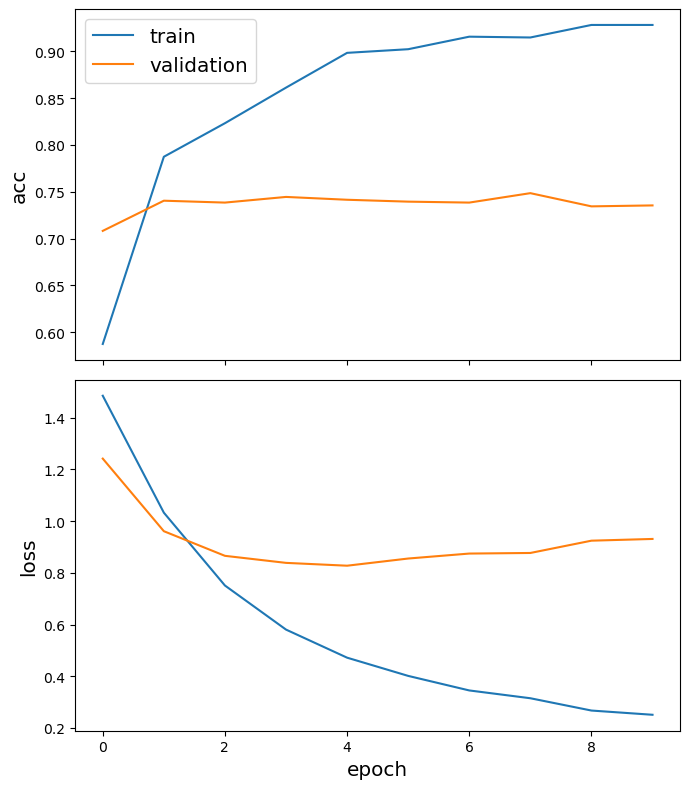

In [20]:
sg.utils.plot_history(history)

In [21]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

20/20 [==============================] - 4s 179ms/step - loss: 0.9344 - acc: 0.7324

Test Set Metrics:
	loss: 0.9344
	acc: 0.7324


### Benchmark model

In [22]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

67/67 [==============================] - 12s 178ms/step


In [23]:
node_predictions = le.inverse_transform(all_predictions)

In [24]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
100157,AI,Agents
364207,Agents,Agents
38848,DB,Agents
bradshaw97introduction,HCI,HCI
bylund99coordinating,HCI,HCI
dix01metaagent,DB,Agents
gray99finding,DB,Agents
labrou01standardizing,Agents,Agents
labrou99agent,Agents,Agents
nodine98overview,DB,DB


In [27]:
# Calculate benchmark metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(df['True'], df['Predicted'])

print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )
print( "Accuracy: ", accuracy )
print( "Confusion Matrix:\n ", cm )
print( "Classification Report: ", cr )


Precision:  0.8919082125603864
Recall:  0.8919082125603864
F1:  0.8919082125603864
Accuracy:  0.8919082125603864
Confusion Matrix:
  [[189  15  14   6   6  19]
 [ 14 543  10   7   5  17]
 [  5   8 648  10  17  13]
 [  0  12   7 466  14   9]
 [  2   6  37  11 581  31]
 [ 17   5  12  10  19 527]]
Classification Report:                precision    recall  f1-score   support

          AI       0.83      0.76      0.79       249
      Agents       0.92      0.91      0.92       596
          DB       0.89      0.92      0.91       701
         HCI       0.91      0.92      0.92       508
          IR       0.90      0.87      0.89       668
          ML       0.86      0.89      0.87       590

    accuracy                           0.89      3312
   macro avg       0.89      0.88      0.88      3312
weighted avg       0.89      0.89      0.89      3312



## GCN model

In [28]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects, random_state=42
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [29]:
train_subjects.value_counts().to_frame() # why is equal to demo?

,0
DB,491
IR,467
Agents,417
ML,413
HCI,356
AI,174


In [30]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [31]:
generator = FullBatchNodeGenerator(SG, method="gcn")

Using GCN (local pooling) filters...


In [32]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [33]:
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [34]:
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [35]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [36]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [38]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.7871 - acc: 0.2079 - val_loss: 1.7445 - val_acc: 0.2837 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.7401 - acc: 0.2860 - val_loss: 1.6765 - val_acc: 0.3964 - 299ms/epoch - 299ms/step
Epoch 3/200
1/1 - 0s - loss: 1.6693 - acc: 0.3568 - val_loss: 1.5880 - val_acc: 0.4326 - 332ms/epoch - 332ms/step
Epoch 4/200
1/1 - 0s - loss: 1.5792 - acc: 0.4090 - val_loss: 1.4975 - val_acc: 0.4527 - 336ms/epoch - 336ms/step
Epoch 5/200
1/1 - 0s - loss: 1.4887 - acc: 0.4362 - val_loss: 1.4097 - val_acc: 0.5392 - 297ms/epoch - 297ms/step
Epoch 6/200
1/1 - 0s - loss: 1.3998 - acc: 0.5190 - val_loss: 1.3214 - val_acc: 0.6761 - 297ms/epoch - 297ms/step
Epoch 7/200
1/1 - 0s - loss: 1.3112 - acc: 0.6260 - val_loss: 1.2404 - val_acc: 0.7223 - 295ms/epoch - 295ms/step
Epoch 8/200
1/1 - 0s - loss: 1.2247 - acc: 0.7010 - val_loss: 1.1653 - val_acc: 0.7425 - 253ms/epoch - 253ms/step
Epoch 9/200
1/1 - 0s - loss: 1.1475 - acc: 0.7330 - val_loss: 1.0920 - val_acc: 0.7445 - 259ms

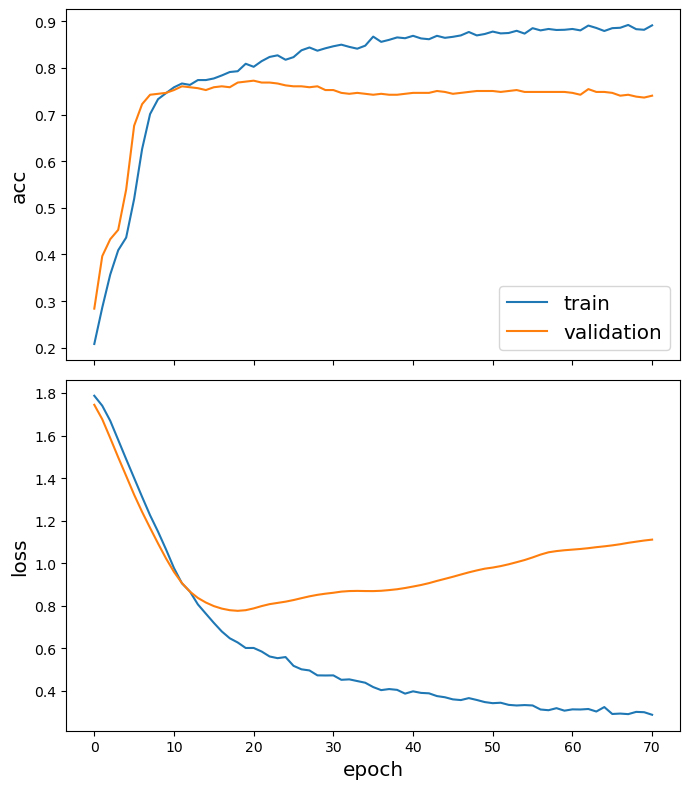

In [39]:
sg.utils.plot_history(history)

In [40]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [41]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 108ms/step - loss: 0.7361 - acc: 0.7706

Test Set Metrics:
	loss: 0.7361
	acc: 0.7706


### Benchmark model

In [45]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

node_predictions = le.inverse_transform(all_predictions.squeeze())

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

1/1 [==============================] - 0s 113ms/step


,Predicted,True
100157,Agents,Agents
364207,Agents,Agents
38848,Agents,Agents
bradshaw97introduction,AI,HCI
bylund99coordinating,HCI,HCI
dix01metaagent,AI,Agents
gray99finding,AI,Agents
labrou01standardizing,Agents,Agents
labrou99agent,Agents,Agents
nodine98overview,Agents,DB


In [46]:
# Calculate benchmark metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(df['True'], df['Predicted'])

print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )
print( "Accuracy: ", accuracy )
print( "Confusion Matrix:\n ", cm )
print( "Classification Report:\n ", cr )

Precision:  0.8294082125603864
Recall:  0.8294082125603864
F1:  0.8294082125603864
Accuracy:  0.8294082125603864
Confusion Matrix:
  [[131  24  21  10  11  52]
 [ 21 539   3  14   8  11]
 [ 23  18 591  12  42  15]
 [ 13  22   3 432  28  10]
 [  1  16  32   8 577  34]
 [ 18  23  15   8  49 477]]
Classification Report:
                precision    recall  f1-score   support

          AI       0.63      0.53      0.57       249
      Agents       0.84      0.90      0.87       596
          DB       0.89      0.84      0.87       701
         HCI       0.89      0.85      0.87       508
          IR       0.81      0.86      0.83       668
          ML       0.80      0.81      0.80       590

    accuracy                           0.83      3312
   macro avg       0.81      0.80      0.80      3312
weighted avg       0.83      0.83      0.83      3312



# GAT model

In [42]:
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

In [47]:
# split data
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [48]:
from collections import Counter

Counter(train_subjects)

Counter({'Agents': 417,
         'ML': 413,
         'IR': 467,
         'DB': 491,
         'AI': 174,
         'HCI': 356})

In [49]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [50]:
# Create the GAT model
generator = FullBatchNodeGenerator(SG, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [53]:
gat = GAT(
    layer_sizes=[32, 32],
    activations=["relu", "relu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [54]:
x_inp, x_out = gat.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [55]:
model = Model(inputs=x_inp, outputs= predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [56]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

Epoch 1/200
1/1 - 5s - loss: 1.8149 - acc: 0.1454 - val_loss: 1.6881 - val_acc: 0.5835 - 5s/epoch - 5s/step
Epoch 2/200
1/1 - 1s - loss: 1.6801 - acc: 0.4124 - val_loss: 1.5236 - val_acc: 0.6901 - 591ms/epoch - 591ms/step
Epoch 3/200
1/1 - 1s - loss: 1.5265 - acc: 0.5259 - val_loss: 1.3229 - val_acc: 0.7223 - 539ms/epoch - 539ms/step
Epoch 4/200
1/1 - 0s - loss: 1.3458 - acc: 0.5966 - val_loss: 1.1288 - val_acc: 0.7264 - 491ms/epoch - 491ms/step
Epoch 5/200
1/1 - 1s - loss: 1.1945 - acc: 0.6350 - val_loss: 0.9723 - val_acc: 0.7344 - 518ms/epoch - 518ms/step
Epoch 6/200
1/1 - 1s - loss: 1.0419 - acc: 0.6868 - val_loss: 0.8642 - val_acc: 0.7445 - 653ms/epoch - 653ms/step
Epoch 7/200
1/1 - 1s - loss: 0.9227 - acc: 0.7097 - val_loss: 0.8027 - val_acc: 0.7425 - 570ms/epoch - 570ms/step
Epoch 8/200
1/1 - 1s - loss: 0.8679 - acc: 0.7209 - val_loss: 0.7831 - val_acc: 0.7686 - 603ms/epoch - 603ms/step
Epoch 9/200
1/1 - 0s - loss: 0.7999 - acc: 0.7412 - val_loss: 0.7878 - val_acc: 0.7666 - 471ms

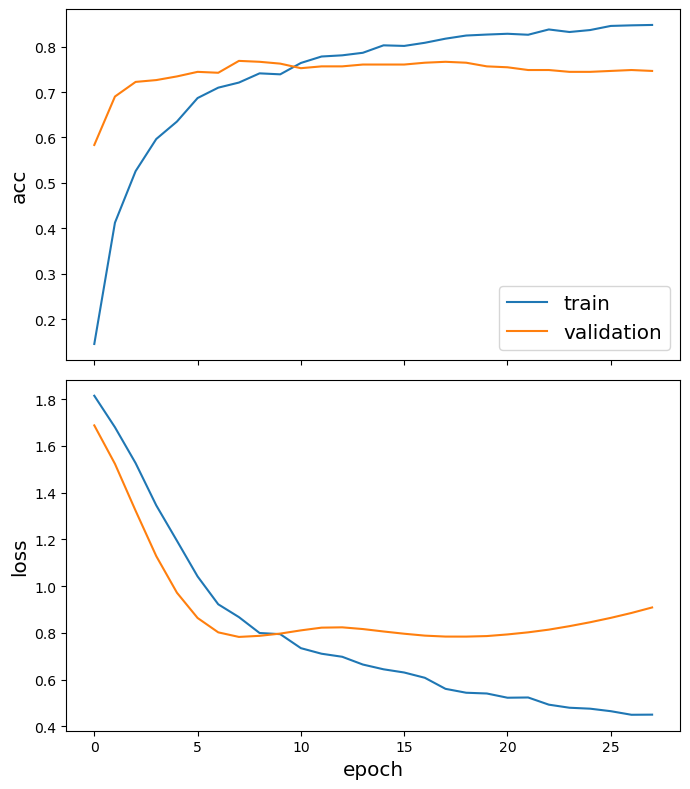

In [58]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)
sg.utils.plot_history(history)


In [59]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 141ms/step - loss: 0.7267 - acc: 0.7787

Test Set Metrics:
	loss: 0.7267
	acc: 0.7787


### Benchmark model

In [60]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

node_predictions = le.inverse_transform(all_predictions.squeeze())

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

1/1 [==============================] - 1s 1s/step


,Predicted,True
100157,Agents,Agents
364207,Agents,Agents
38848,Agents,Agents
bradshaw97introduction,Agents,HCI
bylund99coordinating,Agents,HCI
dix01metaagent,DB,Agents
gray99finding,Agents,Agents
labrou01standardizing,Agents,Agents
labrou99agent,Agents,Agents
nodine98overview,Agents,DB


In [61]:
# Calculate benchmark metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(df['True'], df['Predicted'])

print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )
print( "Accuracy: ", accuracy )
print( "Confusion Matrix:\n ", cm )
print( "Classification Report:\n ", cr )

Precision:  0.7964975845410628
Recall:  0.7964975845410628
F1:  0.7964975845410628
Accuracy:  0.7964975845410628
Confusion Matrix:
  [[ 43  46  45  16  13  86]
 [  2 539  14  16   5  20]
 [  3  17 613  14  43  11]
 [  0  33  11 428  27   9]
 [  0  17  53  13 548  37]
 [  4  29  19  15  56 467]]
Classification Report:
                precision    recall  f1-score   support

          AI       0.83      0.17      0.29       249
      Agents       0.79      0.90      0.84       596
          DB       0.81      0.87      0.84       701
         HCI       0.85      0.84      0.85       508
          IR       0.79      0.82      0.81       668
          ML       0.74      0.79      0.77       590

    accuracy                           0.80      3312
   macro avg       0.80      0.73      0.73      3312
weighted avg       0.80      0.80      0.78      3312

